In [ ]:
import copy
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Qiskit imports
from qiskit.algorithms.minimum_eigensolvers import QAOA
from qiskit.algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler
from qiskit.utils.algorithm_globals import algorithm_globals
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.converters.quadratic_program_to_qubo import QuadraticProgramToQubo
from qiskit_optimization.problems.variable import VarType
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization import QuadraticProgram

from docplex.mp.model import Model


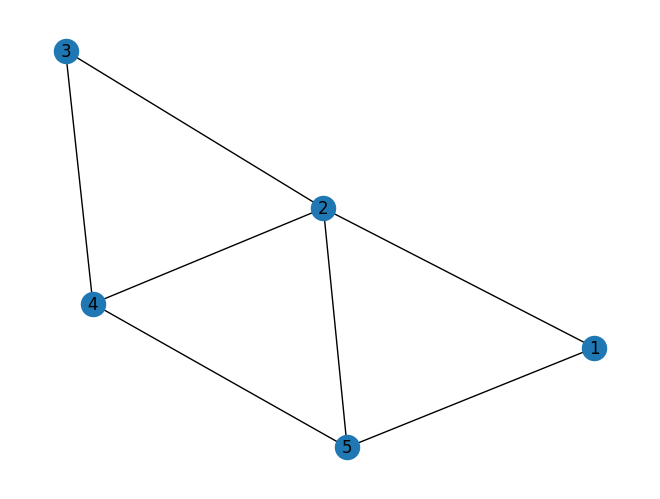

In [2]:
def draw_graph(n, e):
    G= nx.Graph()
    G.add_nodes_from([i for i in range(1, n+1)])
    G.add_edges_from(e)
    nx.draw(G, with_labels=True)
    return G

n=5
e = [(1,2), (1,5), (2,3), (2,4), (2,5), (3,4), (4,5)]
G = draw_graph(n,e)

In [3]:

num_nodes = G.number_of_nodes()
num_color = 3
P = 4
Q = np.eye(num_nodes * num_color)
for i in range(1, num_nodes +1):
    l = num_color * i + 1
    for j in range(l-num_color,l):
        for k in range(l-num_color, l):
            if k==j:
                Q[j-1][k-1] = -P
            else:
                Q[j-1][k-1] = P



for i, j in G.edges:
    for k in range(1, num_color+1):
        # (node -1) * num_color + k
        m = (i-1) * num_color + k
        o = (j-1) * num_color + k
        Q[m-1][o-1] = P/2
        Q[o-1][m-1] = P/2        

print(Q)


[[-4.  4.  4.  2.  0.  0.  0.  0.  0.  0.  0.  0.  2.  0.  0.]
 [ 4. -4.  4.  0.  2.  0.  0.  0.  0.  0.  0.  0.  0.  2.  0.]
 [ 4.  4. -4.  0.  0.  2.  0.  0.  0.  0.  0.  0.  0.  0.  2.]
 [ 2.  0.  0. -4.  4.  4.  2.  0.  0.  2.  0.  0.  2.  0.  0.]
 [ 0.  2.  0.  4. -4.  4.  0.  2.  0.  0.  2.  0.  0.  2.  0.]
 [ 0.  0.  2.  4.  4. -4.  0.  0.  2.  0.  0.  2.  0.  0.  2.]
 [ 0.  0.  0.  2.  0.  0. -4.  4.  4.  2.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  2.  0.  4. -4.  4.  0.  2.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  2.  4.  4. -4.  0.  0.  2.  0.  0.  0.]
 [ 0.  0.  0.  2.  0.  0.  2.  0.  0. -4.  4.  4.  2.  0.  0.]
 [ 0.  0.  0.  0.  2.  0.  0.  2.  0.  4. -4.  4.  0.  2.  0.]
 [ 0.  0.  0.  0.  0.  2.  0.  0.  2.  4.  4. -4.  0.  0.  2.]
 [ 2.  0.  0.  2.  0.  0.  0.  0.  0.  2.  0.  0. -4.  4.  4.]
 [ 0.  2.  0.  0.  2.  0.  0.  0.  0.  0.  2.  0.  4. -4.  4.]
 [ 0.  0.  2.  0.  0.  2.  0.  0.  0.  0.  0.  2.  4.  4. -4.]]


In [4]:
mdl = Model(name ="GC")
x = [mdl.binary_var('x%s' % i) for i in range (len(Q))]
objective = mdl.sum([x[i]* Q[i,j] * x[j] for i in range(len(Q)) for j in range(len(Q))])
mdl.minimize(objective)
qp = from_docplex_mp(mdl)

print(qp.prettyprint())

Problem name: GC

Minimize
  -4*x0^2 + 8*x0*x1 + 4*x0*x12 + 8*x0*x2 + 4*x0*x3 - 4*x1^2 + 4*x1*x13 + 8*x1*x2
  + 4*x1*x4 - 4*x10^2 + 8*x10*x11 + 4*x10*x13 - 4*x11^2 + 4*x11*x14 - 4*x12^2
  + 8*x12*x13 + 8*x12*x14 - 4*x13^2 + 8*x13*x14 - 4*x14^2 + 4*x2*x14 - 4*x2^2
  + 4*x2*x5 + 4*x3*x12 - 4*x3^2 + 8*x3*x4 + 8*x3*x5 + 4*x3*x6 + 4*x3*x9
  + 4*x4*x10 + 4*x4*x13 - 4*x4^2 + 8*x4*x5 + 4*x4*x7 + 4*x5*x11 + 4*x5*x14
  - 4*x5^2 + 4*x5*x8 - 4*x6^2 + 8*x6*x7 + 8*x6*x8 + 4*x6*x9 + 4*x7*x10 - 4*x7^2
  + 8*x7*x8 + 4*x8*x11 - 4*x8^2 + 8*x9*x10 + 8*x9*x11 + 4*x9*x12 - 4*x9^2

Subject to
  No constraints

  Binary variables (15)
    x0 x1 x2 x3 x4 x5 x6 x7 x8 x9 x10 x11 x12 x13 x14



In [6]:
algorithm_globals.random_seed = 12345
qaoa_mes = QAOA(sampler=Sampler(), optimizer=COBYLA())
qaoa = MinimumEigenOptimizer(qaoa_mes)

qaoa_result = qaoa.solve(qp)
print(qaoa_result.prettyprint())
print("---R---")
print(qaoa_result.x)

objective function value: -20.0
variable values: x0=0.0, x1=1.0, x2=0.0, x3=0.0, x4=0.0, x5=1.0, x6=1.0, x7=0.0, x8=0.0, x9=0.0, x10=1.0, x11=0.0, x12=1.0, x13=0.0, x14=0.0
status: SUCCESS
---R---
[0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.]


In [7]:
def assign_color(result, num_color):
    colors = ["BLUE", "GREEN", "RED", "YELLOW", "ORANGE", "PINK", "BLACK", "BROWN", "WHITE", "PURPLE", "VIOLET"]
    color_map = list()
    for pos, val in enumerate(result.x):
      if int(val) == 1:    
            node = pos//num_color + 1
            color = pos%num_color
            color_map.append(colors[color])
            print("for node %s with bin var %s the assigned color is %s"%(node, pos, colors[color]))
    return color_map
    
qaoa_color_map = assign_color(qaoa_result,3)

for node 1 with bin var 1 the assigned color is GREEN
for node 2 with bin var 5 the assigned color is RED
for node 3 with bin var 6 the assigned color is BLUE
for node 4 with bin var 10 the assigned color is GREEN
for node 5 with bin var 12 the assigned color is BLUE


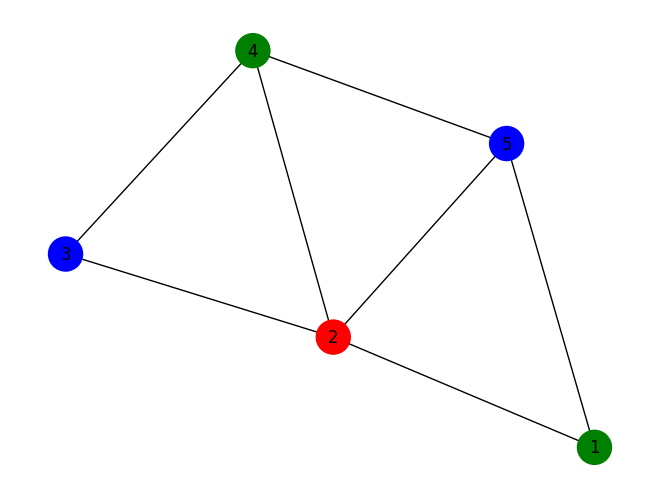

In [8]:

def draw_color_graph(n, e, color_map):
    G= nx.Graph()
    G.add_nodes_from([i for i in range(1, n+1)])
    G.add_edges_from(e)
    nx.draw(G, node_color=color_map, node_size=600, with_labels= True)

    return G

gra = draw_color_graph(n, e, qaoa_color_map)